## data load

## functions

In [1]:
# Modified from Portal:
# Zhao J, et al. (2022) Adversarial domain translation networks for integrating large-scale atlas-level single-cell datasets. Nature Computational Science 2(5):317-330.

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


class encoder(nn.Module):
    def __init__(self, n_input, n_latent):
        super(encoder, self).__init__()
        self.n_input = n_input
        self.n_latent = n_latent
        n_hidden = 512

        self.W_1 = nn.Parameter(torch.Tensor(n_hidden, self.n_input).normal_(mean=0.0, std=0.1))
        self.b_1 = nn.Parameter(torch.Tensor(n_hidden).normal_(mean=0.0, std=0.1))

        self.W_2 = nn.Parameter(torch.Tensor(self.n_latent, n_hidden).normal_(mean=0.0, std=0.1))
        self.b_2 = nn.Parameter(torch.Tensor(self.n_latent).normal_(mean=0.0, std=0.1))

    def forward(self, x):
        h = F.relu(F.linear(x, self.W_1, self.b_1))
        z = F.linear(h, self.W_2, self.b_2)
        return z

class generator(nn.Module):
    def __init__(self, n_input, n_latent):
        super(generator, self).__init__()
        self.n_input = n_input
        self.n_latent = n_latent
        n_hidden = 512

        self.W_1 = nn.Parameter(torch.Tensor(n_hidden, self.n_latent).normal_(mean=0.0, std=0.1))
        self.b_1 = nn.Parameter(torch.Tensor(n_hidden).normal_(mean=0.0, std=0.1))

        self.W_2 = nn.Parameter(torch.Tensor(self.n_input, n_hidden).normal_(mean=0.0, std=0.1))
        self.b_2 = nn.Parameter(torch.Tensor(self.n_input).normal_(mean=0.0, std=0.1))

    def forward(self, z):
        h = F.relu(F.linear(z, self.W_1, self.b_1))
        x = F.linear(h, self.W_2, self.b_2)
        return x

class discriminator(nn.Module):
    def __init__(self, n_input):
        super(discriminator, self).__init__()
        self.n_input = n_input
        n_hidden = 512

        self.W_1 = nn.Parameter(torch.Tensor(n_hidden, self.n_input).normal_(mean=0.0, std=0.1))
        self.b_1 = nn.Parameter(torch.Tensor(n_hidden).normal_(mean=0.0, std=0.1))

        self.W_2 = nn.Parameter(torch.Tensor(n_hidden, n_hidden).normal_(mean=0.0, std=0.1))
        self.b_2 = nn.Parameter(torch.Tensor(n_hidden).normal_(mean=0.0, std=0.1))

        self.W_3 = nn.Parameter(torch.Tensor(1, n_hidden).normal_(mean=0.0, std=0.1))
        self.b_3 = nn.Parameter(torch.Tensor(1).normal_(mean=0.0, std=0.1))

    def forward(self, x):
        h = F.relu(F.linear(x, self.W_1, self.b_1))
        h = F.relu(F.linear(h, self.W_2, self.b_2))
        score = F.linear(h, self.W_3, self.b_3)
        return torch.clamp(score, min=-50.0, max=50.0)

class encoder_site(nn.Module):
    def __init__(self, n_input, n_latent):
        super(encoder_site, self).__init__()
        self.n_input = n_input
        self.n_latent = n_latent
        n_hidd_1 = 1000
        n_hidd_2 = 500
        n_hidd_3 = 50
        n_hidd_4 = 10

        self.fc1 = nn.Linear(n_input, n_hidd_1)
        self.fc1_bn = nn.BatchNorm1d(n_hidd_1)
        self.fc2 = nn.Linear(n_hidd_1, n_hidd_2)
        self.fc2_bn = nn.BatchNorm1d(n_hidd_2)
        self.fc3 = nn.Linear(n_hidd_2, n_hidd_3)
        self.fc3_bn = nn.BatchNorm1d(n_hidd_3)
        self.fc4 = nn.Linear(n_hidd_3, n_hidd_4)
        self.fc4_bn = nn.BatchNorm1d(n_hidd_4)
        self.fc5 = nn.Linear(n_hidd_4, n_latent)

    def forward(self, input):
        h1 = F.relu(self.fc1_bn(self.fc1(input)))
        h2 = F.relu(self.fc2_bn(self.fc2(h1)))
        h3 = F.relu(self.fc3_bn(self.fc3(h2)))
        h4 = F.relu(self.fc4_bn(self.fc4(h3)))
        #return F.relu(self.fc5(h4))
        return self.fc5(h4)

class decoder_site(nn.Module):
    def __init__(self, n_input, n_latent):
        super(decoder_site, self).__init__()
        self.n_input = n_input
        self.n_latent = n_latent
        n_hidd_6 = 10
        n_hidd_7 = 50
        n_hidd_8 = 500
        n_hidd_9 = 1000
        self.fc6 = nn.Linear(n_latent, n_hidd_6)
        self.fc6_bn = nn.BatchNorm1d(n_hidd_6)
        self.fc7 = nn.Linear(n_hidd_6, n_hidd_7)
        self.fc7_bn = nn.BatchNorm1d(n_hidd_7)
        self.fc8 = nn.Linear(n_hidd_7, n_hidd_8)
        self.fc8_bn = nn.BatchNorm1d(n_hidd_8)
        self.fc9 = nn.Linear(n_hidd_8, n_hidd_9)
        self.fc9_bn = nn.BatchNorm1d(n_hidd_9)
        self.fc10 = nn.Linear(n_hidd_9, n_input)

    def forward(self, z):
        h6 = F.relu(self.fc6_bn(self.fc6(z)))
        h7 = F.relu(self.fc7_bn(self.fc7(h6)))
        h8 = F.relu(self.fc8_bn(self.fc8(h7)))
        h9 = F.relu(self.fc9_bn(self.fc9(h8)))
        return self.fc10(h9)

In [2]:
import os
import numpy as np
import scanpy as sc
import pandas as pd
import anndata

import ot

import torch
import torch.nn as nn
import torch.nn.functional as F

loss1 = nn.L1Loss()
loss2 = nn.MSELoss()

def get_max_index(
    vector
):
    """This function Returns the index of the vector's maximum value.

        Args:
            vector: A vector that store values.

        Return:
            max_index: The index of the vector's maximum value.
    """
    max_index=np.where(vector==np.max(vector))[0][0]
    return max_index

def trans_plan_b(
    latent_A,
    latent_B,
    metric='correlation',
    reg=0.1,
    numItermax=10,
    device='cpu'
):
    """This function Returns the optimal transport (OT) plan.

        Args:
            latent_A, latent_B: Two set of data points.
            metric: Metric of OT. Default is 'correlation'.
            reg: The weight of entropy regularized term. Default is 0.1.
            numItermax: Iterations of OT. Default is 10.

        Return:
            plan: The index of the vector's maximum value.
    """
    cost = ot.dist(latent_A.detach().cpu().numpy(), latent_B.detach().cpu().numpy(), metric=metric)
    cost = torch.from_numpy(cost).float().to(device)

    length_A = latent_A.shape[0]
    length_B = latent_B.shape[0]

    P = torch.exp(-cost/reg)

    p_s = torch.ones(length_A, 1) / length_A
    p_t = torch.ones(length_B, 1) / length_B
    p_s = p_s.to(device)
    p_t = p_t.to(device)

    u_s = torch.ones(length_A, 1) / length_A
    u_t = torch.ones(length_B, 1) / length_B
    u_s = u_s.to(device)
    u_t = u_t.to(device)

    for i in range(numItermax):
        p_t = u_t / torch.mm(torch.transpose(P, 0, 1), p_s)
        p_s = u_s / torch.mm(P, p_t)

    plan = torch.transpose(p_t, 0, 1) * P * p_s

    return plan

def rand_projections(
    embedding_dim,
    num_samples=50,
    device='cpu'
):
    """This function generates `num_samples` random samples from the latent space's unit sphere.

        Args:
            embedding_dim (int): embedding dimensionality
            num_samples (int): number of random projection samples

        Return:
            torch.Tensor: tensor of size (num_samples, embedding_dim)
    """

    projections = [w / np.sqrt((w**2).sum())  # L2 normalization
                   for w in np.random.normal(size=(num_samples, embedding_dim))]
    projections = np.asarray(projections)
    return torch.from_numpy(projections).type(torch.FloatTensor).to(device)


def _sliced_wasserstein_distance(
    encoded_samples,
    distribution_samples,
    num_projections=50,
    p=2,
    device='cpu'
):
    """ Sliced Wasserstein Distance between encoded samples and drawn distribution samples.

        Args:
            encoded_samples (toch.Tensor): tensor of encoded training samples
            distribution_samples (torch.Tensor): tensor of drawn distribution training samples
            num_projections (int): number of projections to approximate sliced wasserstein distance
            p (int): power of distance metric
            device (torch.device): torch device (default 'cpu')

        Return:
            torch.Tensor: tensor of wasserstrain distances of size (num_projections, 1)
    """

    # derive latent space dimension size from random samples drawn from latent prior distribution
    embedding_dim = distribution_samples.size(1)
    # generate random projections in latent space
    projections = rand_projections(embedding_dim, num_projections).to(device)
    # calculate projections through the encoded samples
    encoded_projections = encoded_samples.matmul(projections.transpose(0, 1).to(device))
    # calculate projections through the prior distribution random samples
    distribution_projections = (distribution_samples.matmul(projections.transpose(0, 1)))
    # calculate the sliced wasserstein distance by
    # sorting the samples per random projection and
    # calculating the difference between the
    # encoded samples and drawn random samples
    # per random projection
    wasserstein_distance = (torch.sort(encoded_projections.transpose(0, 1), dim=1)[0] -
                            torch.sort(distribution_projections.transpose(0, 1), dim=1)[0])
    # distance between latent space prior and encoded distributions
    # power of 2 by default for Wasserstein-2
    wasserstein_distance = torch.pow(wasserstein_distance, p)
    # approximate mean wasserstein_distance for each projection
    return wasserstein_distance.mean()


def sliced_wasserstein_distance(
    encoded_samples,
    transformed_samples,
    num_projections=50,
    p=2,
    device='cpu'
):
    """ Sliced Wasserstein Distance between encoded samples and drawn distribution samples.

        Args:
            encoded_samples (toch.Tensor): tensor of encoded training samples
            distribution_samples (torch.Tensor): tensor of drawn distribution training samples
            num_projections (int): number of projections to approximate sliced wasserstein distance
            p (int): power of distance metric
            device (torch.device): torch device (default 'cpu')

        Return:
            torch.Tensor: tensor of wasserstrain distances of size (num_projections, 1)
    """
    swd = _sliced_wasserstein_distance(encoded_samples, transformed_samples, num_projections, p, device)
    return swd

ModuleNotFoundError: No module named 'scanpy'

## ours

In [33]:
# Modified from Portal:
# Zhao J, et al. (2022) Adversarial domain translation networks for integrating large-scale atlas-level single-cell datasets. Nature Computational Science 2(5):317-330.
import os
import time
import numpy as np
import scanpy as sc
import pandas as pd
import tables
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.decomposition import PCA, IncrementalPCA
import scipy.sparse as sp
from scipy.spatial.distance import cdist
from tqdm import tqdm

class Model3(object):
    def __init__(self,
                 beta=1.0,
                 lambda_Lasso=0.1,
                 resolution = "low", # Resolution of ST dataset. Available options are: "low" and "high".
                 batch_size = 500, # Batch size.
                 train_epoch = 5000, # Epochs.
                 cut_steps = 0.5, # Switch location between integration network and localization network training.
                 seed = 1234, # Random seed.
                 npcs = 30, # Number of top PCs.
                 n_latent = 20, # Dimension of shared latent space on integration network.
                 n_coord = 2, # Dimension of spatial location.
                 sf_coord = 12000, # scaling factor of spatial location.
                 location = "spatial", # storing location of spatial location.
                 rad_cutoff = None, # The distance of the location cell from the nearest spot is used to filter out cells located outside the tissue section.
                 lambdaGAN = 1.0, # The weight of adversarial learning loss on integration network.
                 lambdacos = 20.0, # The weight of cosine similarity on integration network.
                 lambdaAE = 10.0, # The weight of auto-encoder consistency on integration network.
                 lambdaLA = 10.0, # The weight of latent alignment loss on integration network.
                 lambdaSWD = 5.0, # The weight of sliced Wasserstein distance on integration network.
                 lambdalat = 1.0, # The weight of spatial location fitting loss on localization network.
                 lambdarec = 0.01, # The weight of reconstruction loss on localization network.
                 model_path = "models", # Model save path.
                 data_path = "data", # Data save path.
                 result_path = "results", # Result save path.
                 ot = True, # Whether to perform minibatch optimal transport. Available options are: True and False.
                 verbose = True, # Whether to print running information. Available options are: True and False.
                 device = "cpu" # The device of model running. Specific graphic card should be specified if use GPU.
                 ):

        # set random seed
        torch.manual_seed(seed)
        np.random.seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.benchmark = True

        if resolution not in ['low', 'high']:
            raise ValueError("Resolution must be either 'low' or 'high'.")

        if resolution == "high" and not ot:
            raise ValueError("If resolution is 'high', ot must be True.")

        self.resolution = resolution
        self.batch_size = batch_size
        self.train_epoch = train_epoch
        if self.resolution == "low":
            self.cut_steps = cut_steps
        elif self.resolution == "high":
            self.cut_steps = 1

        self.npcs = npcs
        self.n_latent = n_latent
        self.n_coord = n_coord
        self.sf_coord = sf_coord
        self.location = location
        self.rad_cutoff = rad_cutoff
        self.beta = beta
        self.lambda_Lasso = lambda_Lasso
        self.lambdaGAN = lambdaGAN
        self.lambdacos = lambdacos
        self.lambdaAE = lambdaAE
        self.lambdaLA = lambdaLA
        self.lambdaSWD = lambdaSWD
        # 在 __init__ 中加上这几行：

        self.lambdalat = lambdalat
        self.lambdarec = lambdarec

        self.margin = 5.0

        self.model_path = model_path
        self.data_path = data_path
        self.result_path = result_path

        self.ot = ot
        self.verbose = verbose
        self.device = device


    def preprocess(self,svg_list,
                   adata_A_input, # Anndata object of scRNA-seq data
                   adata_B_input, # Anndata object of ST data
                   hvg_num = 4000, # Number of highly variable genes for each anndata
                   save_embedding = False, # Save low-dimensional embeddings or not
                   res=1.0
                   ):
        adata_A_input.obs["batch"] = "scRNA-seq"
        adata_B_input.obs["batch"] = "ST"
        adata_A = adata_A_input.copy()
        adata_B = adata_B_input.copy()
        if self.verbose:
            print("Finding highly variable genes...")
        sc.pp.highly_variable_genes(adata_A, flavor='seurat_v3', n_top_genes=hvg_num)
        sc.pp.highly_variable_genes(adata_B, flavor='seurat_v3', n_top_genes=hvg_num)
        hvg_A = adata_A.var[adata_A.var.highly_variable == True].sort_values(by="highly_variable_rank").index
        hvg_B = adata_B.var[adata_B.var.highly_variable == True].sort_values(by="highly_variable_rank").index
        hvg_total = hvg_A.intersection(hvg_B)
        print('# overlap highly variable genes is: '+str(len(hvg_total)))
        if len(hvg_total) < 100:
            raise ValueError("The total number of highly variable genes is smaller than 100 (%d). Try to set a larger hvg_num." % len(hvg_total))
        if self.verbose:
            print("Normalizing and scaling...")
        sc.pp.normalize_total(adata_A, target_sum=1e4)
        sc.pp.log1p(adata_A)
        #temp=adata_A.var
        #temp['rank']=np.arange(temp.shape[0])
        #index_svg=temp.loc[svg_list,:]['rank'].values
        svg_list=list(set(svg_list)&set(adata_A.var.index))
        adata_A_svg = adata_A[:,svg_list].copy()
        sc.pp.scale(adata_A_svg, max_value=10)
        self.emb_svg_A=adata_A_svg.X.copy()
        adata_A0=adata_A.copy()
        sc.tl.pca(adata_A0)
        sc.pp.neighbors(adata_A0)
        sc.tl.umap(adata_A0)
        # Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
        sc.tl.leiden(adata_A0, resolution=res)
        cluster_labels = adata_A0.obs['leiden'].astype(int).values
        K=len(set(cluster_labels))
        adata_A = adata_A[:, hvg_total]
        sc.pp.scale(adata_A, max_value=10)
        sc.pp.normalize_total(adata_B, target_sum=1e4)
        sc.pp.log1p(adata_B)
        #temp=adata_B.var
        #temp['rank']=np.arange(temp.shape[0])
        #index_svg=temp.loc[svg_list,:]['rank'].values
        adata_B_svg = adata_B[:,svg_list].copy()
        sc.pp.scale(adata_B_svg, max_value=10)
        self.emb_svg_B=adata_B_svg.X.copy()
        self.n_svg=adata_B_svg.X.shape[1]
        adata_B = adata_B[:, hvg_total]
        sc.pp.scale(adata_B, max_value=10)
        adata_total = adata_A.concatenate(adata_B, index_unique=None)
        if self.verbose:
            print("Dimensionality reduction via PCA...")
        pca = PCA(n_components=self.npcs, svd_solver="arpack", random_state=0)
        adata_total.obsm["X_pca"] = pca.fit_transform(adata_total.X)
        self.emb_A = adata_total.obsm["X_pca"][:adata_A.shape[0], :self.npcs].copy()
        self.emb_B = adata_total.obsm["X_pca"][adata_A.shape[0]:, :self.npcs].copy()
        #self.emb_B = np.concatenate([emb_svg_B, emb_B], axis=1) 
        self.coord_B = adata_B.obsm[self.location][:, :self.n_coord].copy()/self.sf_coord
        self.adata_total = adata_total
        self.adata_A_input = adata_A_input
        self.adata_B_input = adata_B_input
        if not os.path.exists(self.data_path):
            os.makedirs(self.data_path)
        if save_embedding:
            np.save(os.path.join(self.data_path, "lowdim_A.npy"), self.emb_A)
            np.save(os.path.join(self.data_path, "lowdim_B.npy"), self.emb_B)
        self.K=K
        self.cluster_labels=cluster_labels
        return K,cluster_labels

    def train(self,training_idx_rna,training_idx_st,
              num_projections = 500, # The same as sliced_wasserstein_distance function and _sliced_wasserstein_distance function.
              metric = 'correlation', # The same as trans_plan_b function.
              reg = 0.1, # The same as trans_plan_b function.
              numItermax = 10 # The same as trans_plan_b function.
              ):
        begin_time = time.time()
        if self.verbose:
            print("Begining time: ", time.asctime(time.localtime(begin_time)))
        self.E_A = encoder(self.npcs, self.n_latent).to(self.device)
        self.E_B = encoder(self.npcs, self.n_latent).to(self.device)
        self.G_A = generator(self.npcs, self.n_latent).to(self.device)
        self.G_B = generator(self.npcs, self.n_latent).to(self.device)
        self.D_A = discriminator(self.npcs).to(self.device)
        self.D_B = discriminator(self.npcs).to(self.device)
        self.E_s = encoder_site(self.n_latent+self.n_svg, self.n_coord).to(self.device)
        #self.D_s = decoder_site(self.n_latent+self.n_svg, self.n_coord).to(self.device) 
        
        x_A = torch.from_numpy(self.emb_A).float().to(self.device)
        z_A = self.E_A(x_A)
        # 将 z_A 转换为 DataFrame 并添加标签列
        df = pd.DataFrame(z_A.detach().numpy())
        df.index = self.cluster_labels
        # 按标签分组并计算每组的均值
        mean_values = df.groupby(df.index).mean().values
        self.phi = nn.Parameter(torch.ones(self.K)/self.K, requires_grad=True).to(self.device)
        self.mu = nn.Parameter(torch.tensor(mean_values), requires_grad=True).to(self.device)
        self.sigma = nn.Parameter(torch.eye(self.n_latent).unsqueeze(0).repeat(self.K, 1, 1), requires_grad=True).to(self.device)
        #print(z_A.shape,x_A.shape,self.mu.shape,K)
        params_G = list(self.E_A.parameters()) + list(self.E_B.parameters()) + list(self.G_A.parameters()) + \
        list(self.G_B.parameters())+[self.mu,self.phi]
        params_S = list(self.E_s.parameters()) #+ list(self.D_s.parameters())
        optimizer_G = optim.Adam(params_G, lr=0.001, weight_decay=0.)
        optimizer_S = optim.Adam(params_S, lr=0.001, weight_decay=0.)
        params_D = list(self.D_A.parameters()) + list(self.D_B.parameters())
        optimizer_D = optim.Adam(params_D, lr=0.001, weight_decay=0.)
        self.E_A.train()
        self.E_B.train()
        self.G_A.train()
        self.G_B.train()
        self.E_s.train()
        #self.D_s.train()
        self.D_A.train()
        self.D_B.train()
        def gmm_log_likelihood(z):
            """计算GMM负对数似然（公式15）"""
            z = z.unsqueeze(1)  # [batch, 1, latent]
            #print(z.shape,self.mu.shape,self.phi.shape)
            diff = z - self.mu  # [batch, K, latent]
            cov_inv = torch.stack([torch.inverse(s) for s in self.sigma])  # [K, latent, latent]
            #print(z.shape,diff.shape,self.sigma.shape,self.phi.shape)
            exponent = -0.5 * torch.einsum('bki,kij,bkj->bk', diff, cov_inv, diff)        
            log_prob = exponent - 0.5 * torch.logdet(self.sigma).unsqueeze(0) + torch.log(self.phi)
            return -torch.logsumexp(log_prob, dim=1).mean()  # 负对数似然
        N_A = len(training_idx_rna)
        N_B = len(training_idx_st)
        if self.ot:
            plan = np.ones(shape=(N_A, N_B))
            plan = plan / (self.batch_size * self.batch_size)
            plan = torch.from_numpy(plan).float().to(self.device)
        emb_svg_B = torch.from_numpy(self.emb_svg_B).float().to(self.device)
        for j in range(self.train_epoch):
            index_A = np.random.choice(training_idx_rna, size=self.batch_size)
            index_B = np.random.choice(training_idx_st, size=self.batch_size)
            x_A = torch.from_numpy(self.emb_A[index_A, :]).float().to(self.device)
            #print(x_A.shape)
            x_B = torch.from_numpy(self.emb_B[index_B, :]).float().to(self.device)
            c_B = torch.from_numpy(self.coord_B[index_B, :]).float().to(self.device)#真实的细胞位置
            z_A = self.E_A(x_A)
            z_B = self.E_B(x_B)
            #z_A1 = np.concatenate([self.emb_svg_A, z_A], axis=1)
            z_B1 =  torch.cat([emb_svg_B[index_B,:], z_B.detach()], dim=1)
            m_B = self.E_s(z_B1)
            #s_Brecon = self.D_s(m_B)
            x_AtoB = self.G_B(z_A)
            x_BtoA = self.G_A(z_B)
            x_Arecon = self.G_A(z_A)
            x_Brecon = self.G_B(z_B)
            z_AtoB = self.E_B(x_AtoB)
            z_BtoA = self.E_A(x_BtoA)
            if j < int(self.train_epoch*self.cut_steps):
                optimizer_D.zero_grad()
                if j <= 5:
                    # Warm-up
                    loss_D_A = (torch.log(1 + torch.exp(-self.D_A(x_A))) + torch.log(
                        1 + torch.exp(self.D_A(x_BtoA)))).mean()
                    loss_D_B = (torch.log(1 + torch.exp(-self.D_B(x_B))) + torch.log(
                        1 + torch.exp(self.D_B(x_AtoB)))).mean()
                else:
                    loss_D_A = (torch.log(
                        1 + torch.exp(-torch.clamp(self.D_A(x_A), -self.margin, self.margin))) + torch.log(
                        1 + torch.exp(torch.clamp(self.D_A(x_BtoA), -self.margin, self.margin)))).mean()
                    loss_D_B = (torch.log(
                        1 + torch.exp(-torch.clamp(self.D_B(x_B), -self.margin, self.margin))) + torch.log(
                        1 + torch.exp(torch.clamp(self.D_B(x_AtoB), -self.margin, self.margin)))).mean()
                loss_D = loss_D_A + loss_D_B
                loss_D.backward(retain_graph=True)
                optimizer_D.step()
                loss_AE_A = torch.mean((x_Arecon - x_A) ** 2)
                loss_AE_B = torch.mean((x_Brecon - x_B) ** 2)
                loss_AE = loss_AE_A + loss_AE_B
                loss_cos_A = (1 - torch.sum(F.normalize(x_AtoB, p=2) * F.normalize(x_A, p=2), 1)).mean()
                loss_cos_B = (1 - torch.sum(F.normalize(x_BtoA, p=2) * F.normalize(x_B, p=2), 1)).mean()
                loss_cos = loss_cos_A + loss_cos_B

                loss_LA_AtoB = torch.mean((z_A - z_AtoB) ** 2)
                loss_LA_BtoA = torch.mean((z_B - z_BtoA) ** 2)
                loss_LA = loss_LA_AtoB + loss_LA_BtoA

                loss_SWD = sliced_wasserstein_distance(z_A, z_B, num_projections=num_projections, device=self.device)

                if self.ot:
                    plan_tmp = trans_plan_b(z_A, z_B, metric=metric, reg=reg, numItermax=numItermax, device=self.device)

                    coord_list = [[i, j] for i in index_A for j in index_B]
                    coord_list = np.array(coord_list)
                    plan[coord_list[:, 0], coord_list[:, 1]] = plan_tmp.reshape([self.batch_size * self.batch_size, ])

                #if j <= 5:
                    # Warm-up
                    #loss_GAN = (torch.log(1 + torch.exp(-self.D_A(x_BtoA))) + torch.log(
                    #    1 + torch.exp(-self.D_B(x_AtoB)))).mean()
                #else:
                    #loss_GAN = (torch.log(
                    #    1 + torch.exp(-torch.clamp(self.D_A(x_BtoA), -self.margin, self.margin))) + torch.log(
                    #    1 + torch.exp(-torch.clamp(self.D_B(x_AtoB), -self.margin, self.margin)))).mean()

                optimizer_G.zero_grad()
                #loss_G =  self.lambdacos * loss_cos + self.lambdaAE * loss_AE + self.lambdaLA * loss_LA + self.lambdaSWD * loss_SWD
                loss_GMM = gmm_log_likelihood(z_A)  # 仅对scRNA数据
                #pi = torch.softmax(torch.mm(z_B, self.mu.T), dim=1)  # [batch, K]
                from sklearn.linear_model import Lasso
                lasso = Lasso(alpha=0.01, fit_intercept=False)
                #print(self.mu.shape)
                #print(z_B.shape)
                from sklearn.linear_model import Lasso
                D, N = z_B.T.shape
                K = self.mu.shape[0]
                pi_all = np.zeros((N, K))
                X = self.mu.detach().cpu().numpy().T # shape = [D x K]
                lasso = Lasso(alpha=0.01, fit_intercept=False, max_iter=1000)
                z=z_B.detach().cpu().numpy().T
                #print(X)
                for i in range(N):
                    y = z[:, i]  # 当前样本 ∈ ℝ^D
                    lasso.fit(X, y)
                    pi_all[i] = lasso.coef_  # 存储第 i 个样本的系数 π_i
                #lasso.fit(self.mu., )  # mu.T: [D x K], z: [D]
                pi = torch.from_numpy(pi_all).float().to(self.device) # 稀疏组合系数 ∈ ℝ^K

                # 计算线性组合损失 (公式17第一项)
                spot_emb_comb = torch.mm(pi, self.mu)  # [batch, latent]
                loss_deconv_lin = torch.mean(torch.norm(z_B - spot_emb_comb, dim=1)**2) / (2 * self.n_latent)               
                # 计算Lasso正则化 (公式17第二项) 
                loss_deconv_l1 = torch.mean(torch.norm(pi, p=1, dim=1))     
                loss_deconv = loss_deconv_lin + self.lambda_Lasso * loss_deconv_l1
                loss_G = 0.1* loss_GMM + self.beta *loss_deconv + self.lambdacos * loss_cos + self.lambdaAE * loss_AE + self.lambdaLA * loss_LA + self.lambdaSWD * loss_SWD         
                loss_G.backward()
                optimizer_G.step()               
                if not j % 500:
                    if self.verbose:
                        print(pi.shape)
                        print("step %d, total_loss=%.4f, loss_D=%.4f, loss_GAN=%.4f, loss_AE=%.4f, loss_cos=%.4f, loss_LA=%.4f, loss_SWD=%.4f"
                              % (j, loss_G, loss_D, 0, loss_AE, loss_cos, loss_LA, loss_SWD))
            else:
                optimizer_S.zero_grad()
                loss_lat = loss1(m_B, c_B) + 0.1 * sliced_wasserstein_distance(m_B, c_B, num_projections=num_projections, device=self.device)
                #loss_rec = loss2(s_Brecon, z_B) + 0.1 * loss1(s_Brecon, z_B)
                loss_S = self.lambdalat * loss_lat #+ self.lambdarec * loss_rec
                loss_S.backward()
                optimizer_S.step()
                if not j % 500:
                    if self.verbose:
                        print("step %d, loss_lat=%.4f" % (j, loss_lat))
                        
        torch.save(self.sigma.detach(),os.path.join(self.result_path, 'sigma.pt') )
        torch.save(self.mu.detach(),os.path.join(self.result_path,  'mu.pt'))
        torch.save(self.phi.detach(), os.path.join(self.result_path,'phi.pt'))
        end_time = time.time()
        if self.verbose:
            print("Ending time: ", time.asctime(time.localtime(end_time)))
        self.train_time = end_time - begin_time
        if self.verbose:
            print("Training takes %.2f seconds" % self.train_time)
        if self.ot:
            self.plan = plan.detach().cpu().numpy()
        if not os.path.exists(self.model_path):
            os.makedirs(self.model_path)
        state = {'D_A': self.D_A.state_dict(), 'D_B': self.D_B.state_dict(),
                 'E_A': self.E_A.state_dict(), 'E_B': self.E_B.state_dict(),
                 'G_A': self.G_A.state_dict(), 'G_B': self.G_B.state_dict(),
                 'E_s': self.E_s.state_dict()}
        torch.save(state, os.path.join(self.model_path, "ckpt.pth"))
        np.save(os.path.join(self.model_path, "pi.npy"), pi.detach().cpu().numpy())
 
    def eval2(self, D_score=False, save_embedding=False, hvg_num=4000, retain_prop=1, detect_aberrant=False, alpha=0.05):
        self.E_A = encoder(self.npcs, self.n_latent).to(self.device)
        self.E_B = encoder(self.npcs, self.n_latent).to(self.device)
        self.G_A = generator(self.npcs, self.n_latent).to(self.device)
        self.G_B = generator(self.npcs, self.n_latent).to(self.device)
        self.E_s = encoder_site(self.n_latent+self.n_svg, self.n_coord).to(self.device)
        #self.D_s = decoder_site(self.n_latent, self.n_coord).to(self.device)
        self.E_A.load_state_dict(torch.load(os.path.join(self.model_path, "ckpt.pth"))['E_A'])
        self.E_B.load_state_dict(torch.load(os.path.join(self.model_path, "ckpt.pth"))['E_B'])
        self.G_A.load_state_dict(torch.load(os.path.join(self.model_path, "ckpt.pth"))['G_A'])
        self.G_B.load_state_dict(torch.load(os.path.join(self.model_path, "ckpt.pth"))['G_B'])
        self.E_s.load_state_dict(torch.load(os.path.join(self.model_path, "ckpt.pth"))['E_s'])
        #self.D_s.load_state_dict(torch.load(os.path.join(self.model_path, "ckpt.pth"))['D_s'])
        emb_svg_B = torch.from_numpy(self.emb_svg_B).float().to(self.device)
        emb_svg_A = torch.from_numpy(self.emb_svg_A).float().to(self.device)
        x_A = torch.from_numpy(self.emb_A).float().to(self.device)
        x_B = torch.from_numpy(self.emb_B).float().to(self.device)

        z_A = self.E_A(x_A)
        z_B = self.E_B(x_B)
        z_B1 =  torch.cat([emb_svg_B, z_B.detach()], dim=1)
        z_A1 =  torch.cat([emb_svg_A, z_A.detach()], dim=1)
        m_A = self.E_s(z_A1)
        m_B = self.E_s(z_B1)
        x_AtoB = self.G_B(z_A)
        x_BtoA = self.G_A(z_B)
        mu = torch.load(os.path.join(self.result_path, 'mu.pt'))
        sigma = torch.load(os.path.join(self.result_path, 'sigma.pt'))
        phi = torch.load(os.path.join(self.result_path, 'phi.pt'))
        phi=phi.cpu().numpy()
        sigma=sigma.cpu().numpy()
        mu =  mu.cpu().numpy()
        from sklearn.linear_model import Lasso
        if self.resolution == "high":
            retain_cell = retain_prop * self.plan.T.shape[1]
            if retain_cell < 5:
                raise ValueError(
                    "The retained proportion is smaller than 5 (%d). Try to set a larger retain_prop." % retain_cell)
        self.latent = np.concatenate((z_A.detach().cpu().numpy(), z_B.detach().cpu().numpy()), axis=0)
        self.adata_total.obsm['latent'] = self.latent
        self.data_Aspace = np.concatenate((self.emb_A, x_BtoA.detach().cpu().numpy()), axis=0)
        self.data_Bspace = np.concatenate((x_AtoB.detach().cpu().numpy(), self.emb_B), axis=0)

        if self.resolution == "low":
            self.map = np.concatenate((m_A.detach().cpu().numpy(), m_B.detach().cpu().numpy()), axis=0)*self.sf_coord
            self.map_A = m_A.detach().cpu().numpy()*self.sf_coord
            self.map_B = m_B.detach().cpu().numpy()*self.sf_coord

        self.adata_total.obs["batch"] = self.adata_total.obs["batch"].replace(["0", "1"], ["scRNA-seq", "ST"])

        if not os.path.exists(self.result_path):
            os.makedirs(self.result_path)

        # Add map results, save adata_total
        if self.resolution == "low":
            self.adata_total.obsm['loc'] = self.map
            self.adata_B_input.obsm["loc"] = self.map_B
            self.adata_A_input.obsm["loc"] = self.map_A
        self.adata_total.write(os.path.join(self.result_path, "adata_total.h5ad"))

        # Normalization, save adata_sc and adata_ST
        sc.pp.highly_variable_genes(self.adata_A_input, flavor="seurat_v3", n_top_genes=hvg_num)
        sc.pp.normalize_total(self.adata_A_input, target_sum=1e4)
        sc.pp.log1p(self.adata_A_input)
        self.adata_A_input.write(os.path.join(self.result_path, "adata_sc.h5ad"))

        sc.pp.highly_variable_genes(self.adata_B_input, flavor="seurat_v3", n_top_genes=hvg_num)
        sc.pp.normalize_total(self.adata_B_input, target_sum=1e4)
        sc.pp.log1p(self.adata_B_input)
        self.adata_B_input.write(os.path.join(self.result_path, "adata_ST.h5ad"))
        # keep cells inside section, save adata_sc_keep
        if self.resolution == "low":
            dist_with_spot = cdist(self.adata_A_input.obsm["loc"], self.adata_B_input.obsm["spatial"])
            min_dist = np.min(dist_with_spot, axis=1)
            self.adata_A_keep = self.adata_A_input[min_dist <= self.rad_cutoff]
            if 'spatial' in self.adata_B_input.uns:
                self.adata_A_keep.uns["spatial"] = self.adata_B_input.uns["spatial"]
                self.adata_A_keep.obsm["spatial"] = self.adata_A_keep.obsm["loc"]
            self.adata_A_keep.write(os.path.join(self.result_path, "adata_sc_keep.h5ad"))
            if self.verbose:
                print("Localized scRNA-seq dataset has been saved!")

        # save OT plan
        if self.ot:
            self.plan_df = pd.DataFrame(self.plan, index=self.adata_A_input.obs.index,
                                        columns=self.adata_B_input.obs.index)
            self.plan_df.index = self.plan_df.index.values
            self.plan_df.to_csv(os.path.join(self.result_path, "trans_plan.csv"))

        # save latent with batch and celltype
        self.latent_df = pd.DataFrame(self.latent, index=self.adata_total.obs.index)
        self.latent_df.columns = ["latent_" + str(x) for x in range(1, self.n_latent + 1)]
        self.latent_df["batch"] = self.adata_total.obs["batch"]
        #self.latent_df["cell_type"] = self.adata_total.obs["celltype"]
        self.latent_df.to_csv(os.path.join(self.result_path, "latent.csv"))

        # save cell type scores
        if self.ot:
            sc_celltype = self.latent_df[self.latent_df["batch"] == "scRNA-seq"]
            #sc_celltype = sc_celltype["cell_type"].astype("str")
            cluster_name = sc_celltype.unique()
            self.cluster_score = np.zeros(shape=(len(cluster_name), self.adata_B_input.shape[0]))
            self.cluster_score = pd.DataFrame(self.cluster_score, index=cluster_name,
                                              columns=self.adata_B_input.obs.index)
            for i in cluster_name:
                self.cluster_score.loc[i, :] = np.mean(self.plan[np.where(sc_celltype == i), :][0], axis=0)
            self.cluster_score = self.cluster_score.T
            self.cluster_score.to_csv(os.path.join(self.result_path, "cluster_score.csv"))

        # save transfer label, maximum probability
        if self.resolution == "high":
            self.trans_label = self.cluster_score.apply(lambda x: get_max_index(x), axis=1)
            self.trans_label = self.trans_label.replace(range(len(self.trans_label.unique())), self.cluster_score.columns)
            self.trans_label = pd.DataFrame(self.trans_label)
            self.trans_label.columns = ["transfer_label"]
            self.trans_label.index = self.adata_B_input.obs.index
            self.trans_label.to_csv(os.path.join(self.result_path, "trans_label.csv"))

        # save transfer data, probability mapping
        if self.resolution == "high":
            retain_cell = retain_prop * self.plan.shape[1]
            plan_filt = self.plan * (np.argsort(np.argsort(self.plan)) >= self.plan.shape[1] - retain_cell)
            self.plan_norm = plan_filt.T / np.sum(plan_filt, 1)
            self.plan_norm = sp.csr_matrix(self.plan_norm)
            self.data_pm = self.plan_norm @ self.adata_A_input.X
            self.adata_ST_pm = sc.AnnData(X=self.data_pm, obs=self.adata_B_input.obs, var=self.adata_A_input.var, obsm=self.adata_B_input.obsm)
            self.adata_ST_pm.write(os.path.join(self.result_path, "adata_ST_pm.h5ad"))
            if self.verbose:
                print("Enhanced ST dataset has been saved!")

        if D_score:
            self.D_A = discriminator(self.npcs).to(self.device)
            self.D_B = discriminator(self.npcs).to(self.device)
            self.D_A.load_state_dict(torch.load(os.path.join(self.model_path, "ckpt.pth"))['D_A'])
            self.D_B.load_state_dict(torch.load(os.path.join(self.model_path, "ckpt.pth"))['D_B'])
            score_D_A_A = self.D_A(x_A)
            score_D_B_A = self.D_B(x_AtoB)
            score_D_B_B = self.D_B(x_B)
            score_D_A_B = self.D_A(x_BtoA)
            self.score_Aspace = np.concatenate((score_D_A_A.detach().cpu().numpy(), score_D_A_B.detach().cpu().numpy()), axis=0)
            self.score_Bspace = np.concatenate((score_D_B_A.detach().cpu().numpy(), score_D_B_B.detach().cpu().numpy()), axis=0)

        if save_embedding:
            np.save(os.path.join(self.result_path, "latent_A.npy"), z_A.detach().cpu().numpy())
            np.save(os.path.join(self.result_path, "latent_B.npy"), z_B.detach().cpu().numpy())
            np.save(os.path.join(self.result_path, "x_AtoB.npy"), x_AtoB.detach().cpu().numpy())
            np.save(os.path.join(self.result_path, "x_BtoA.npy"), x_BtoA.detach().cpu().numpy())
            np.save(os.path.join(self.result_path, "map_A.npy"), m_A.detach().cpu().numpy())
            np.save(os.path.join(self.result_path, "map_B.npy"), m_B.detach().cpu().numpy())
        return mu,phi,sigma,z_A.detach().cpu().numpy(), z_B.detach().cpu().numpy(),m_A.detach().cpu().numpy(),m_B.detach().cpu().numpy()
            #if self.verbose:
                #print(f"Aberrant detection results saved to {os.path.join(self.result_path, 'aberrant_spots.csv')}")


In [9]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
import scanpy as sc
#import STALocator
import scipy.sparse as sp
import torch
from datetime import datetime
# 创建标准化目录结构
experiment_path = "result/SCC"
model_path = os.path.join(experiment_path, "models")
data_path = os.path.join(experiment_path, "data")
result_path = os.path.join(experiment_path, "results")
os.makedirs(model_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)
os.makedirs(result_path, exist_ok=True)
# 读取数据（保持原始代码不变）
adata_ST=sc.read('/home/qyyuan/project/ST_GRN/data/mouse_anterior/adata_ST.h5ad')
adata_sc=sc.read('/home/qyyuan/project/ST_GRN/data/mouse_anterior/adata_sc.h5ad')

In [4]:
svg_list=pd.read_csv('/home/zzhang/SPADE/SpaGCN/tutorial/svg-enhanced-mouse-new.csv',header=0,sep=',',index_col=0)

In [7]:
svg_list=svg_list.index

## model ours 

In [26]:

model = Model3(
    resolution="low",
    batch_size=200,
    train_epoch=1000,
    cut_steps=0.5,
    sf_coord=50,
    rad_cutoff=1.2,
    seed=1234,
    lambdacos=10,
    lambdaSWD=5,
    lambdalat=10,
    lambdarec=0.1,
    model_path=model_path,
    data_path=data_path,
    result_path=result_path,
    ot=False,
    device="cpu"
)


In [27]:
# 检查重复基因名（可选）
print(f"重复基因名: {adata_sc.var_names.duplicated().sum()}")

# 删除重复基因，仅保留第一次出现
adata_sc = adata_sc[:, ~adata_sc.var_names.duplicated()]



重复基因名: 0


In [28]:
adata_ST= adata_ST[:, ~adata_ST.var_names.duplicated()]

In [29]:
K,cluster=model.preprocess(svg_list,adata_sc, adata_ST,res=0.5)

Finding highly variable genes...
# overlap highly variable genes is: 2061
Normalizing and scaling...
Dimensionality reduction via PCA...


In [30]:
Y=adata_ST.obs[['x','y']].values
Y = Y.astype(np.float32)
N_st=adata_ST.X.shape[0]
N_rna=adata_sc.X.shape[0]
import numpy as np

def sample_two_thirds(N_st):
    """
    从0到N_st-1中随机抽取2/3的样本
    """
    total_samples = np.arange(N_st)  # 创建0到N_st-1的数组
    sample_size = int(2/3 * N_st)   # 计算需要抽取的样本数量
    
    # 随机抽取不重复的样本
    sampled_indices = np.random.choice(total_samples, size=sample_size, replace=False)
    
    return sorted(sampled_indices)  # 返回排序后的索引

training_idx_rna=np.array(range(N_rna))
training_idx_st = sample_two_thirds(N_st)

In [31]:

    model.train(training_idx_rna,training_idx_st)

Begining time:  Fri Aug 29 22:57:24 2025
torch.Size([200, 26])
step 0, total_loss=893.8407, loss_D=17.1725, loss_GAN=0.0000, loss_AE=46.6551, loss_cos=1.9276, loss_LA=35.6695, loss_SWD=9.4586
step 500, loss_lat=1.4055
Ending time:  Sat Aug 30 00:02:27 2025
Training takes 3903.39 seconds


In [32]:
mu,phi,sigma,z_A, z_B,m_A,m_B=model.eval2()

Localized scRNA-seq dataset has been saved!


KeyError: 'celltype'

In [ ]:
min_st=adata_ST.obsm['spatial'].min()-1
max_st=adata_ST.obsm['spatial'].max()+1
y_real=adata_ST.obsm['spatial']/50

In [ ]:
text_idx=list(set(range(m_B.shape[0]))-set(training_idx_st))
np.abs(m_B[text_idx,:]- y_real[text_idx,:]).mean(axis=0)

array([0.12552713, 0.07795066])

### result1: GMM cluster scRNA

In [325]:
        X=z_B.copy()
        responsibilities = np.zeros((X.shape[0], K))
        from scipy.stats import multivariate_normal
            # 假设你有 mu, sigma, X，K 是高斯分布数
        for k in range(K):
            rv = multivariate_normal(mean=mu[k], cov=sigma[k])
            responsibilities[:, k] = phi[k] * rv.pdf(X)
            responsibilities1 = responsibilities/responsibilities.sum(axis=1, keepdims=True)
            labels = np.argmax(responsibilities, axis=1)
        X=z_A.copy()
        responsibilities_A = np.zeros((X.shape[0], K))
        from scipy.stats import multivariate_normal
        for k in range(K):
            rv = multivariate_normal(mean=mu[k], cov=sigma[k])
            responsibilities_A[:, k] = phi[k] * rv.pdf(X)
            responsibilities_A1 = responsibilities_A/responsibilities_A.sum(axis=1, keepdims=True)
            labels_A = np.argmax(responsibilities_A1, axis=1)

In [ ]:
from collections import Counter
# Count frequencies
freq = Counter(labels_A)
#df = pd.DataFrame(list(freq.items()), columns=['Category', 'Count'])
df = pd.DataFrame(freq.items(), columns=['Category', 'Count'])
df =df[df['Count']>50]

freq

Counter({6: 8825,
         5: 5060,
         7: 2875,
         14: 2274,
         3: 1793,
         20: 1761,
         10: 1152,
         0: 593,
         1: 508,
         4: 463,
         8: 398,
         17: 304,
         2: 240,
         9: 49,
         19: 4})

In [342]:
df = pd.DataFrame(list(freq.items()), columns=['Category', 'Count'])
df1=pd.DataFrame(phi,columns=['phi'])
#df1.columns=[['phi']]
df1['Category']=[i for i in range(K)]

In [362]:
df = pd.DataFrame(freq.items(), columns=['Category', 'Count'])
df =df[df['Count']>50]

In [344]:
merged_df = pd.merge(df, df1, on='Category', how='outer')

# 填充缺失值为 0
merged_df.fillna({'Count': 0}, inplace=True)


In [347]:
merged_df.sort_values(by='Count', ascending=False, inplace=True)

In [348]:
merged_df

,Category,Count,phi
0,6,8825.0,1.506581
8,5,5060.0,1.673027
6,7,2875.0,1.535144
1,14,2274.0,0.668628
4,3,1793.0,1.250541
2,20,1761.0,1.445120
9,10,1152.0,1.194639
3,0,593.0,1.070757
11,1,508.0,0.707519
10,4,463.0,0.818823


In [ ]:
import pandas as pd
labels1 = labels_A
labels2 = adata_sc.obs['level2_celltype'].values
# 转为 Series
s1 = pd.Series(labels1, name="labels1")
s2 = pd.Series(labels2, name="labels2")
# 用 crosstab 统计交叉表
matrix = pd.crosstab(s1, s2)
pd.DataFrame(matrix).to_csv('temp.csv')


In [ ]:
import pandas as pd
labels1 = labels_A
labels2 = adata_sc.obs['level2_celltype'].values
# 转为 Series
s1 = pd.Series(labels1, name="labels1")
s2 = pd.Series(labels2, name="labels2")
# 用 crosstab 统计交叉表
matrix = pd.crosstab(s1, s2)
pd.DataFrame(matrix).to_csv('temp1.csv')


In [ ]:
                from sklearn.linear_model import Lasso
                D, N = z_B.T.shape
                K = mu.shape[0]
                pi_all = np.zeros((N, K))
                X = mu.T # shape = [D x K]
                lasso = Lasso(alpha=0.01, fit_intercept=False, max_iter=1000)
                z=z_B.T
                #print(X)
                for i in range(N):
                    y = z[:, i]  # 当前样本 ∈ ℝ^D
                    lasso.fit(X, y)
                    pi_all[i] = lasso.coef_  # 存储第 i 个样本的系数 π_i
                #lasso.fit(self.mu., )  # mu.T: [D x K], z: [D]


In [ ]:
np.savez(os.path.join(result_path,"model_outputs.npz"), 
         mu=mu, 
         phi=phi, 
         sigma=sigma, 
         z_A=z_A, 
         z_B=z_B, 
         m_A=m_A, 
         m_B=m_B, 
         pi=pi_all,labels_RNA=labels_A)

In [ ]:
# 加载数据
data = np.load(os.path.join(result_path, "model_outputs.npz"))
# 提取各个变量
mu = data['mu']
phi = data['phi']
sigma = data['sigma']
z_A = data['z_A']
z_B = data['z_B']
m_A = data['m_A']
m_B = data['m_B']
pi_all = data['pi']
labels_A = data['labels_RNA']
# 关闭文件（可选，但在处理完数据后关闭是个好习惯）
data.close()

from collections import Counter
# Count frequencies
freq = Counter(labels_A)
#df = pd.DataFrame(list(freq.items()), columns=['Category', 'Count'])
df = pd.DataFrame(freq.items(), columns=['Category', 'Count'])
df =df[df['Count']>50]

freq

Counter({6: 8564,
         5: 4944,
         7: 2878,
         14: 2483,
         3: 1798,
         20: 1754,
         10: 1158,
         0: 608,
         1: 586,
         4: 480,
         8: 427,
         17: 307,
         2: 256,
         9: 52,
         19: 4})

In [40]:
pd.DataFrame(m_A).to_csv('map_A.csv')
adata_sc.obs['level2_celltype'].to_csv('labels.csv')

In [42]:
pd.DataFrame(labels_A).to_csv('clusters.csv')

In [12]:
import umap
import matplotlib.pyplot as plt
import numpy as np
X = z_A.copy()

# Create UMAP reducer
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)

# Fit and transform
X_umap = reducer.fit_transform(X)
X_new_umap = reducer.transform(mu)

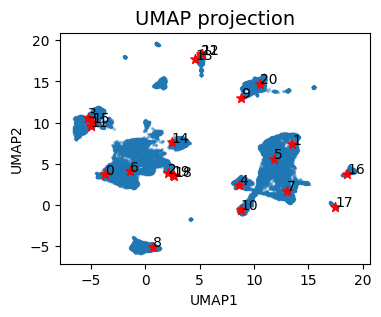

In [14]:
# Plot
point_labels=[i for i in range(K)]
texts = []

plt.figure(figsize=(4, 3))
plt.scatter(X_umap[:, 0], X_umap[:, 1], s=2,alpha=0.3)
plt.scatter(X_new_umap[:, 0], X_new_umap[:, 1], c='red', marker='*', s=50)
plt.title('UMAP projection', fontsize=14)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
for i, label in enumerate(point_labels):
    texts.append(
        plt.text(X_new_umap[i, 0], X_new_umap[i, 1], str(label), fontsize=10)
    )
# 自动调整所有文字，避免重叠
#adjust_text(texts, 
##            only_move={'points': 'y', 'texts': 'y'}, # 可以只上下移动
#            arrowprops=dict(arrowstyle="->", color='gray', lw=0.5)) # 给线加箭头（可选）
plt.savefig(os.path.join(result_path,"umap_projection.pdf"), format='pdf', bbox_inches='tight')  # 保存 PDF 文件
plt.show()

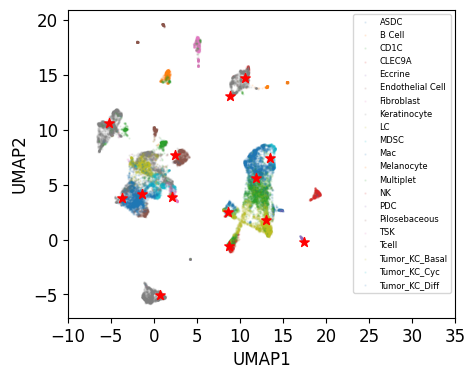

In [34]:
point_labels=[i for i in range(K)]
plt.figure(figsize=(5,4))
plt.xlim(-10, 35)
#plt.scatter(X_umap[:, 0], X_umap[:, 1], s=2, alpha=0.2)
#plt.title('UMAP projection', fontsize=16)
plt.xlabel('UMAP1', fontsize=12)
plt.ylabel('UMAP2', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
labels_train=adata_sc.obs['level2_celltype'].values
unique_labels = np.unique(labels_train)

for label in unique_labels:
    idx = np.array(labels_train) == label
    plt.scatter(X_umap[idx, 0], X_umap[idx, 1], 
                label=label, alpha=0.1,s=0.5)
plt.scatter(X_new_umap[df['Category'], 0], X_new_umap[df['Category'], 1], c='red', marker='*', s=50)

# 这里假设 point_labels 是一个 list 或 array，长度和 X_new_umap 一样
#for i, label in enumerate(df['Category'].values.tolist()):
#    print(i,label)
 #   plt.text(X_new_umap[label, 0], X_new_umap[label, 1]+1, str(label),
#             fontsize=10, color='black', ha='center', va='center')
plt.legend(fontsize=6)
plt.savefig("umap_projection.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
pi=pi_all[:,df['Category'].values.tolist()]
pd.DataFrame(pi,columns=df['Category'].values.tolist()).to_csv('/home/qyyuan/project/ST_GRN/result/SCC/results/pi_forplot.txt',sep='\t')


(666, 13)

In [ ]:
adata_ST.obs.to_csv('/home/qyyuan/project/ST_GRN/result/SCC/results/location.txt',sep='\t')


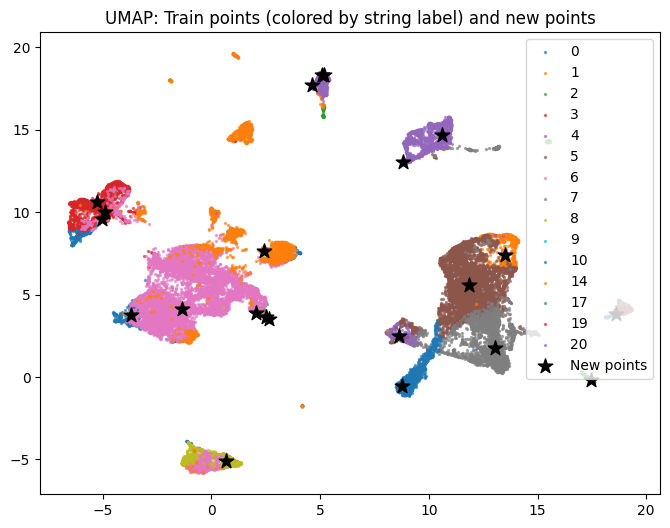

In [ ]:
plt.figure(figsize=(8, 6))
labels_train=adata_sc.obs['level2_celltype'].values
unique_labels = np.unique(labels_train)

for label in unique_labels:
    idx = np.array(labels_train) == label
    plt.scatter(X_umap[idx, 0], X_umap[idx, 1], 
                label=label, alpha=0.6,s=2)

# 新数据点
plt.scatter(X_new_umap[:, 0], X_new_umap[:, 1], 
            c='black', marker='*', s=120, label='New points')

plt.legend()
plt.tight_layout() 
plt.show()

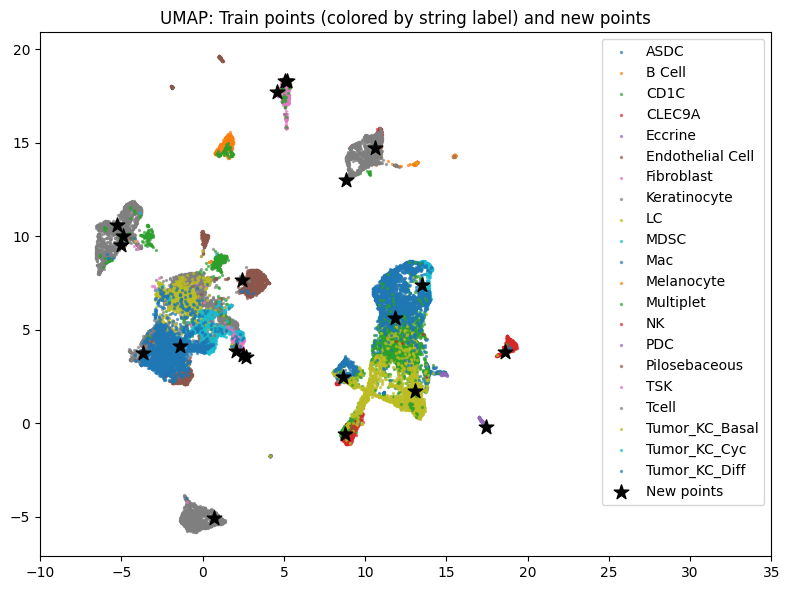

In [13]:
plt.figure(figsize=(8, 6))
# 设置横坐标范围
plt.xlim(-10, 35)
labels_train=adata_sc.obs['level2_celltype'].values
unique_labels = np.unique(labels_train)

for label in unique_labels:
    idx = np.array(labels_train) == label
    plt.scatter(X_umap[idx, 0], X_umap[idx, 1], 
                label=label, alpha=0.6,s=2)

# 新数据点
plt.scatter(X_new_umap[:, 0], X_new_umap[:, 1], 
            c='black', marker='*', s=120, label='New points')

plt.legend()
plt.title('UMAP: Train points (colored by string label) and new points')
plt.tight_layout()  
plt.show()

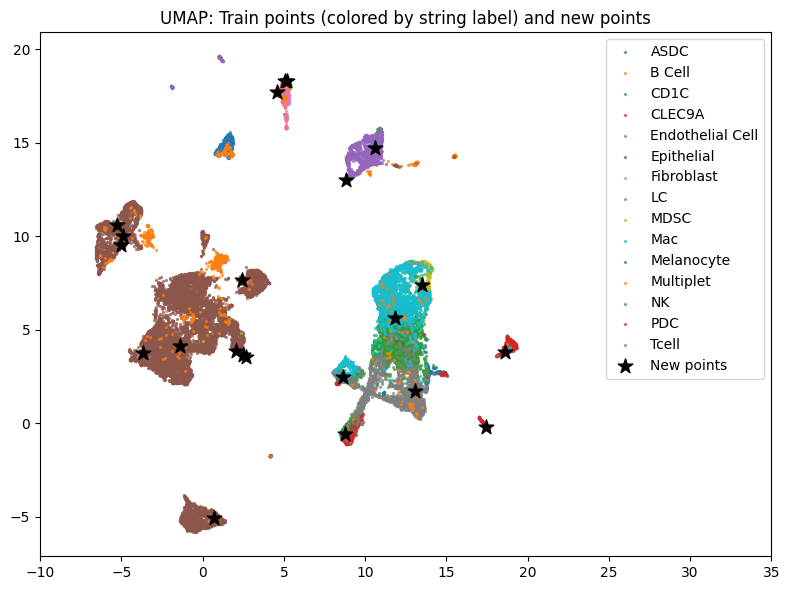

In [ ]:
plt.figure(figsize=(8, 6))
# 设置横坐标范围
plt.xlim(-10, 35)
labels_train=adata_sc.obs['level1_celltype'].values
unique_labels = np.unique(labels_train)

for label in unique_labels:
    idx = np.array(labels_train) == label
    plt.scatter(X_umap[idx, 0], X_umap[idx, 1], 
                label=label, alpha=0.6,s=2)

# 新数据点
plt.scatter(X_new_umap[:, 0], X_new_umap[:, 1], 
            c='black', marker='*', s=120, label='New points')

plt.legend()
plt.title('UMAP: Train points (colored by string label) and new points')
plt.tight_layout()  
plt.show()

In [ ]:
adata=adata_sc.copy()

In [ ]:
# Saving count data
adata.layers["counts"] = adata.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

In [ ]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

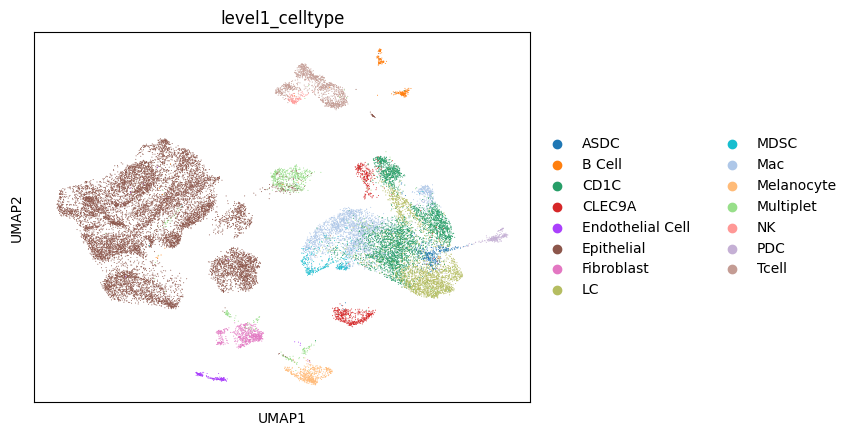

In [ ]:
sc.pl.umap(
    adata,
    color="level1_celltype",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

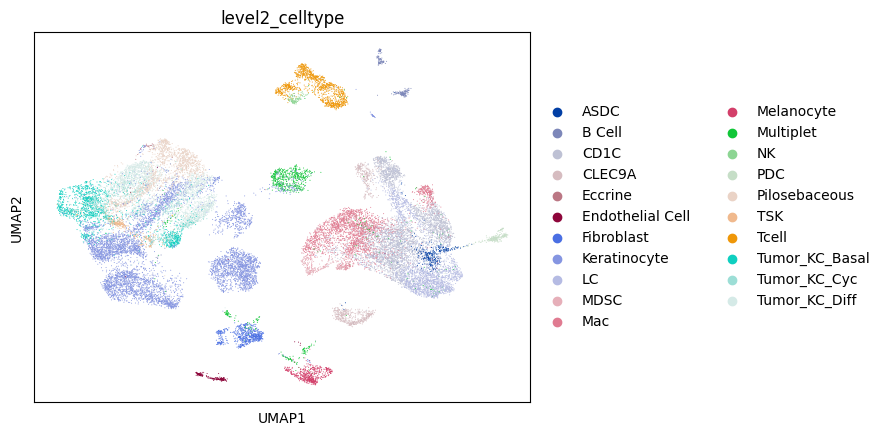

In [ ]:
sc.pl.umap(
    adata,
    color="level2_celltype",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

In [ ]:
z_A0=np.load("/home/qyyuan/project/ST_GRN/result/SCC_original/latent_A.npy")
import umap
import matplotlib.pyplot as plt
import numpy as np
X = z_A0.copy()

# Create UMAP reducer
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)

# Fit and transform
X_umap = reducer.fit_transform(X)

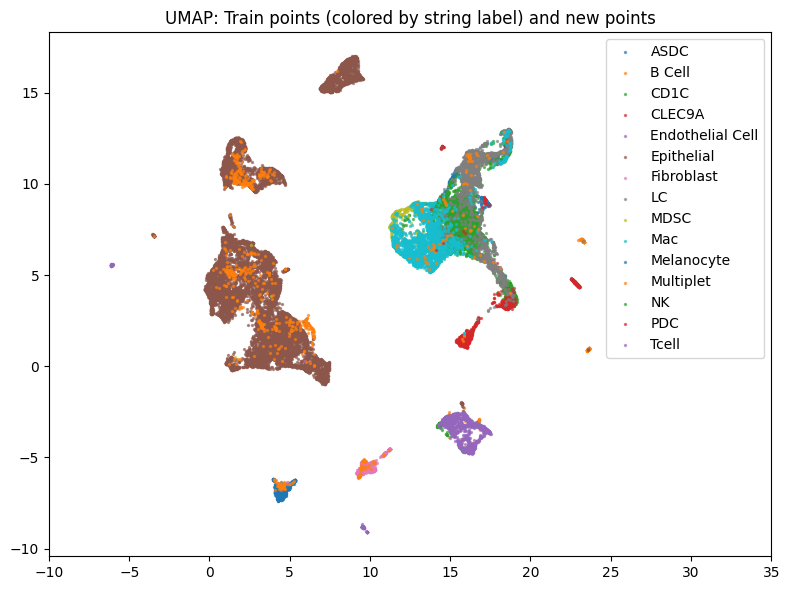

In [ ]:
plt.figure(figsize=(8, 6))
# 设置横坐标范围
plt.xlim(-10, 35)
labels_train=adata_sc.obs['level1_celltype'].values
unique_labels = np.unique(labels_train)

for label in unique_labels:
    idx = np.array(labels_train) == label
    plt.scatter(X_umap[idx, 0], X_umap[idx, 1], 
                label=label, alpha=0.6,s=2)

plt.legend()
plt.title('UMAP: Train points (colored by string label) and new points')
plt.tight_layout()  
plt.show()

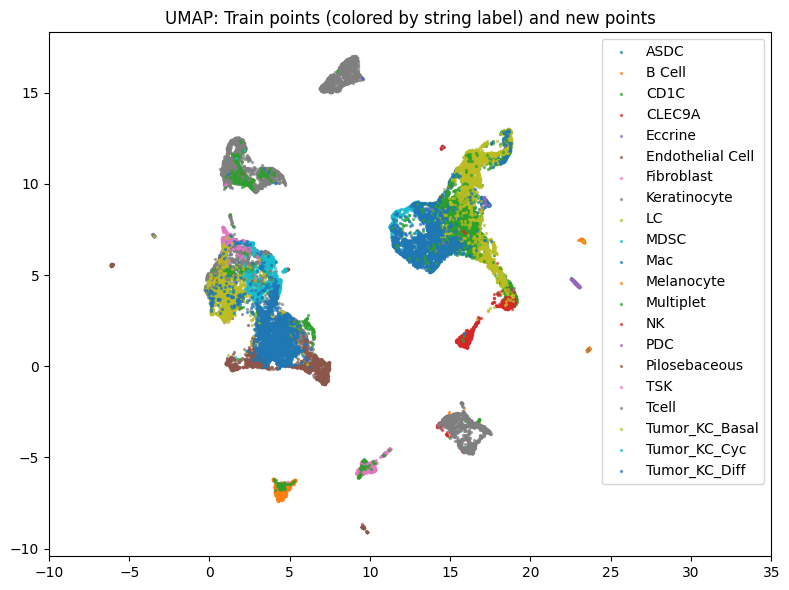

In [ ]:
plt.figure(figsize=(8, 6))
# 设置横坐标范围
plt.xlim(-10, 35)
labels_train=adata_sc.obs['level2_celltype'].values
unique_labels = np.unique(labels_train)

for label in unique_labels:
    idx = np.array(labels_train) == label
    plt.scatter(X_umap[idx, 0], X_umap[idx, 1], 
                label=label, alpha=0.6,s=2)

plt.legend()
plt.title('UMAP: Train points (colored by string label) and new points')
plt.tight_layout()  
plt.show()

### compare origianl and ours 

In [294]:
z_A.shape

(26299, 20)

In [307]:
import numpy as np
from sklearn.metrics import silhouette_score, silhouette_samples
# 举例：X 是 feature * sample, 我们需要转置
# X.shape = (features, samples)
X = z_A  # 转成 shape (samples, features)

labels=adata_sc.obs['level2_celltype'].values

# 整体平均 silhouette index
sil_score = silhouette_score(X, labels, metric='euclidean')
print("Silhouette score (overall):", sil_score)

# 每个 sample 的 silhouette value
sil_values = silhouette_samples(X, labels, metric='euclidean')
print("Per-sample silhouette values shape:", sil_values.shape)


Silhouette score (overall): 0.06282014
Per-sample silhouette values shape: (26299,)


In [308]:
import numpy as np
from sklearn.metrics import silhouette_score, silhouette_samples
# 举例：X 是 feature * sample, 我们需要转置
# X.shape = (features, samples)
X = z_A0  # 转成 shape (samples, features)
labels=adata_sc.obs['level2_celltype'].values
# 整体平均 silhouette index
sil_score = silhouette_score(X, labels, metric='euclidean')
print("Silhouette score (overall):", sil_score)
# 每个 sample 的 silhouette value
sil_values = silhouette_samples(X, labels, metric='euclidean')
print("Per-sample silhouette values shape:", sil_values.shape)


Silhouette score (overall): 0.06277311
Per-sample silhouette values shape: (26299,)


In [305]:
X = adata.obsm['X_pca'][:,:20]
labels=adata_sc.obs['level2_celltype'].values
# 整体平均 silhouette index
sil_score = silhouette_score(X, labels, metric='cosine')
print("Silhouette score (overall):", sil_score)
# 每个 sample 的 silhouette value
sil_values = silhouette_samples(X, labels, metric='euclidean')
print("Per-sample silhouette values shape:", sil_values.shape)

Silhouette score (overall): 0.038480658
Per-sample silhouette values shape: (26299,)


In [310]:
import numpy as np
from sklearn.metrics import silhouette_score, silhouette_samples
# 举例：X 是 feature * sample, 我们需要转置
# X.shape = (features, samples)
X = z_A  # 转成 shape (samples, features)
labels=adata_sc.obs['level1_celltype'].values
# 整体平均 silhouette index
sil_score = silhouette_score(X, labels, metric='euclidean')
print("Silhouette score (overall):", sil_score)
import numpy as np
from sklearn.metrics import silhouette_score, silhouette_samples
# 举例：X 是 feature * sample, 我们需要转置
# X.shape = (features, samples)
X = z_A0  # 转成 shape (samples, features)
labels=adata_sc.obs['level1_celltype'].values
# 整体平均 silhouette index
sil_score = silhouette_score(X, labels, metric='euclidean')
print("Silhouette score (overall):", sil_score)
X = adata.obsm['X_pca'][:,:20]
labels=adata_sc.obs['level1_celltype'].values
# 整体平均 silhouette index
sil_score = silhouette_score(X, labels, metric='euclidean')
print("Silhouette score (overall):", sil_score)


Silhouette score (overall): 0.18009406
Silhouette score (overall): 0.124707706
Silhouette score (overall): 0.23210828


In [311]:
import numpy as np
from sklearn.metrics import silhouette_score, silhouette_samples
# 举例：X 是 feature * sample, 我们需要转置
# X.shape = (features, samples)
X = z_A  # 转成 shape (samples, features)
labels=adata_sc.obs['level3_celltype'].values
# 整体平均 silhouette index
sil_score = silhouette_score(X, labels, metric='euclidean')
print("Silhouette score (overall):", sil_score)
import numpy as np
from sklearn.metrics import silhouette_score, silhouette_samples
# 举例：X 是 feature * sample, 我们需要转置
# X.shape = (features, samples)
X = z_A0  # 转成 shape (samples, features)
labels=adata_sc.obs['level3_celltype'].values
# 整体平均 silhouette index
sil_score = silhouette_score(X, labels, metric='euclidean')
print("Silhouette score (overall):", sil_score)
X = adata.obsm['X_pca'][:,:20]
labels=adata_sc.obs['level3_celltype'].values
# 整体平均 silhouette index
sil_score = silhouette_score(X, labels, metric='euclidean')
print("Silhouette score (overall):", sil_score)


Silhouette score (overall): 0.07434111
Silhouette score (overall): 0.07052556
Silhouette score (overall): 0.046718948


In [ ]:
import numpy as np
from sklearn.metrics import silhouette_score, silhouette_samples
# 举例：X 是 feature * sample, 我们需要转置
# X.shape = (features, samples)
X = z_A  # 转成 shape (samples, features)

labels=adata_sc.obs['level1_celltype'].values

# 整体平均 silhouette index
sil_score = silhouette_score(X, labels, metric='euclidean')
print("Silhouette score (overall):", sil_score)

# 每个 sample 的 silhouette value
sil_values = silhouette_samples(X, labels, metric='euclidean')
print("Per-sample silhouette values shape:", sil_values.shape)


## comformal prediction

In [ ]:
final_aberrant, final_confidence,lambda_calib,pred_coords,true_coords=model.eval2(D_score=True, save_embedding=True, detect_aberrant=True, alpha=0.05)

In [ ]:
final_confidence

In [ ]:
lambda_calib.shape

In [ ]:
import pandas as pd

# 假设这些变量已经是 pandas DataFrame 或 Series
# 如果不是，需要先转换为 DataFrame

# 示例：如果变量是 numpy 数组或其他类型，可以这样转换
final_aberrant = pd.DataFrame(final_aberrant)
final_confidence = pd.DataFrame(final_confidence)
lambda_calib = pd.DataFrame(lambda_calib)
pred_coords = pd.DataFrame(pred_coords)
true_coords = pd.DataFrame(true_coords)

# 保存为 CSV 文件
final_aberrant.to_csv('final_aberrant.csv', index=False)
final_confidence.to_csv('final_confidence.csv', index=False)
lambda_calib.to_csv('lambda_calib.csv', index=False)
pred_coords.to_csv('pred_coords.csv', index=False)
true_coords.to_csv('true_coords.csv', index=False)

In [ ]:
lambda_calib.shape

In [ ]:
final_aberrant.shape

## check the result

In [ ]:
import pandas as pd

In [ ]:
original=pd.read_csv('prediction_cross_orginal0.txt',index_col=0)

In [ ]:
original

In [ ]:
original_adv=pd.read_csv('prediction_cross_orginal.txt',index_col=0)

In [ ]:
original_adv